In [13]:
from pulp import *
import utils
import math
import numpy as np

In [14]:
WIDTH = 0
HEIGHT = 1
TIME_LIMIT = 300

In [15]:
def compute_lb(w, dims, roation):
    n_rows = math.ceil(sum(dims[:, WIDTH]) / w)
    sorted_heights = sorted(dims[:, HEIGHT])
    lb = np.sum(sorted_heights[:n_rows])
    if roation:
        lower_bound = lb
    else:
        lower_bound = lb if lb >= max(dims[:, HEIGHT]) else max(dims[:, HEIGHT])
    
    return lower_bound

In [16]:
def run_LP(w, n, dims, rotation, break_symmetry, log_path):    
    lower_bound = compute_lb(w, dims, rotation)
    upper_bound = sum(dims[:, HEIGHT])
    k = 4
    prob = LpProblem("VLSI", LpMinimize)
    L = LpVariable("L", lower_bound, upper_bound, LpInteger)
    pos_x = LpVariable.dicts("pos_x", range(n), 0, w, LpInteger)
    pos_y = LpVariable.dicts("pos_y", range(n), 0, upper_bound, LpInteger)
    M0 = M1 = w
    M2 = M3 = upper_bound
    pos_chosen = LpVariable.dict("pos_chosen", (range(n), range(n), range(k)), 0, 1, LpInteger)
    rotated = LpVariable.dict("rotated", range(n), 0, 1, LpInteger)
    prob += L

    if rotation:
        for i in range(n):
            prob += L >= pos_y[i] + dims[i, HEIGHT]*(1-rotated[i])+ rotated[i]*dims[i, WIDTH]
            if break_symmetry and dims[i, HEIGHT] == dims[i, WIDTH]:
                # Break symmetry: Not allowed to rotate when it is a square
                prob += rotated[i] == 0
            for j in range(i + 1, n):
                prob += pos_x[i] + (1-rotated[i])*dims[i, WIDTH] + rotated[i]*dims[i, HEIGHT]<= pos_x[j] + M0 * (pos_chosen[i, j, 0])
                prob += pos_x[j] + (1-rotated[j])*dims[j, WIDTH] + rotated[j]*dims[j, HEIGHT] <= pos_x[i] + M1 * (pos_chosen[i, j, 1])
                prob += pos_y[i] + (1-rotated[i])*dims[i, HEIGHT] + rotated[i]*dims[i, WIDTH]<= pos_y[j] + M2 * (pos_chosen[i, j, 2])
                prob += pos_y[j] + (1-rotated[j])*dims[j, HEIGHT] + rotated[j]*dims[j, WIDTH]<= pos_y[i] + M3 * (pos_chosen[i, j, 3])
                prob += lpSum([pos_chosen[i, j, k] for k in range(k)]) <= 3

            prob += pos_x[i] + (1-rotated[i])*dims[i, WIDTH] + rotated[i]*dims[i, HEIGHT] <= M1  

    if not rotation:
        for i in range(n):
            prob += L >= pos_y[i] + dims[i, HEIGHT]
            for j in range(i + 1, n):
                prob += pos_x[i] + dims[i, WIDTH] <= pos_x[j] + M0 * pos_chosen[i, j, 0]
                prob += pos_x[j] + dims[j, WIDTH] <= pos_x[i] + M1 * pos_chosen[i, j, 1]
                prob += pos_y[i] + dims[i, HEIGHT] <= pos_y[j] + M2 * pos_chosen[i, j, 2]
                prob += pos_y[j] + dims[j, HEIGHT] <= pos_y[i] + M3 * pos_chosen[i, j, 3]
                prob += lpSum([pos_chosen[i, j, k] for k in range(k)]) <= k - 1
            prob += pos_x[i] + dims[i, WIDTH] <= M1 

    status = prob.solve(PULP_CBC_CMD(timeLimit=TIME_LIMIT, msg=1, logPath=log_path))
    LpStatus[status]

    sol = []
    sol.append([w, int(value(L))])
    sol.append([n])
    for i in range(n):
        if rotation:
            width = dims[i, int(value(rotated[i]))]
            height = dims[i, 1-int(value(rotated[i]))]
        else:
            width = dims[i, WIDTH]
            height = dims[i, HEIGHT]
        sol.append([width, height, int(value(pos_x[i])), int(value(pos_y[i]))])
    return sol, prob

In [17]:
def make_solution_str(sol):
    w = sol[0][0]
    l = sol[0][1]
    n = sol[1][0]
    str = f"{w} {l}\n{n}\n"

    for i in range(2, len(sol)):
        str += f"{sol[i][0]} {sol[i][1]} {sol[i][2]} {sol[i][3]}\n"
    
    return str

Value of L: 8
Time: 0.06343770027160645


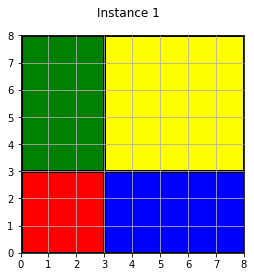

Value of L: 9
Time: 0.09003591537475586


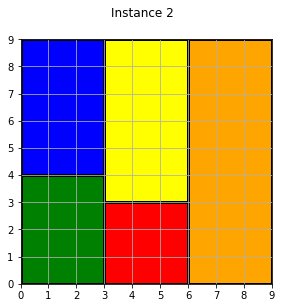

Value of L: 10
Time: 1.4231629371643066


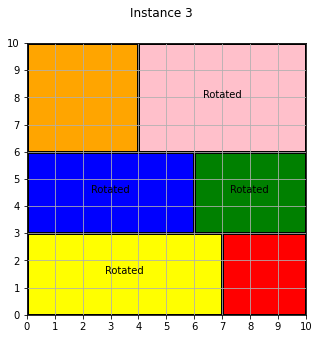

In [19]:
INSTANCE_NUMBER = 2
ALL_SOLUTIONS = False
ROTATION = True
BREAK_SYMMETRY  = True

solutions = []
for i in range(1,4):
    file_path = f"../instances/ins-{i}.txt"
    w, n, dims = utils.read_output(file_path)

    if ROTATION:
        if BREAK_SYMMETRY:
            log_path = f"./MIP_logs/rotation/BS/log_ins-{i}.txt"
        else: 
            log_path = f"./MIP_logs/rotation/notBS/log_ins-{i}.txt"
    else:    
        log_path = f"./MIP_logs/fixed_position/log_ins-{i}.txt"    


    sol, prob = run_LP(w,n, dims, ROTATION, BREAK_SYMMETRY, log_path)

    if (prob.solutionTime>=TIME_LIMIT):
        print(f"Instance {i} timed out")
        sol_str = f"{300}"
    else:
        print(f"Value of L: {sol[0][1]}")
        print(f"Time: {prob.solutionTime}")
        v = utils.visualize_output(sol, dims, i)
        sol_str = make_solution_str(sol)
        sol_str += f"\n{prob.solutionTime}"
    
    

    if BREAK_SYMMETRY and ROTATION:
        output_file = f"./MIP_solutions/rotation_{ROTATION}/break_symmetry/sol_ins-{i}.txt"
    else:
        output_file = f"./MIP_solutions/rotation_{ROTATION}/sol_ins-{i}.txt"
    utils.write_output_to_file(output_file, sol_str)